In [1]:

import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import matplotlib as mtl
import numpy as np

import input_output
import signal_processing
import image_processing


## B

In [2]:
def get_dicts(mouse_number):
    neurons, astrocytes, neurons_ttx, astrocytes_ttx = {},{},{},{}
    for m_info in input_output.mouse_infos(only_mouse=mouse_number, load_ttx=True):
        ss1 = m_info['stimulations_starts'][0]
        n = np.average(m_info['neurons'], axis = (1, 2))
        n = n - np.average(n[:ss1])
        a = np.average(m_info['astrocytes'], axis = (1, 2))
        a = a - np.average(a[:ss1])
        if m_info['is_ttx']:
            neurons_ttx[m_info['current']] = n
            astrocytes_ttx[m_info['current']] = a
        else:
            neurons[m_info['current']] = n
            astrocytes[m_info['current']] = a

    return neurons, astrocytes, neurons_ttx, astrocytes_ttx

neurons, astrocytes, neurons_ttx, astrocytes_ttx = get_dicts(78)
all_dics = [neurons, astrocytes, neurons_ttx, astrocytes_ttx]

(-15.0, 130.0)

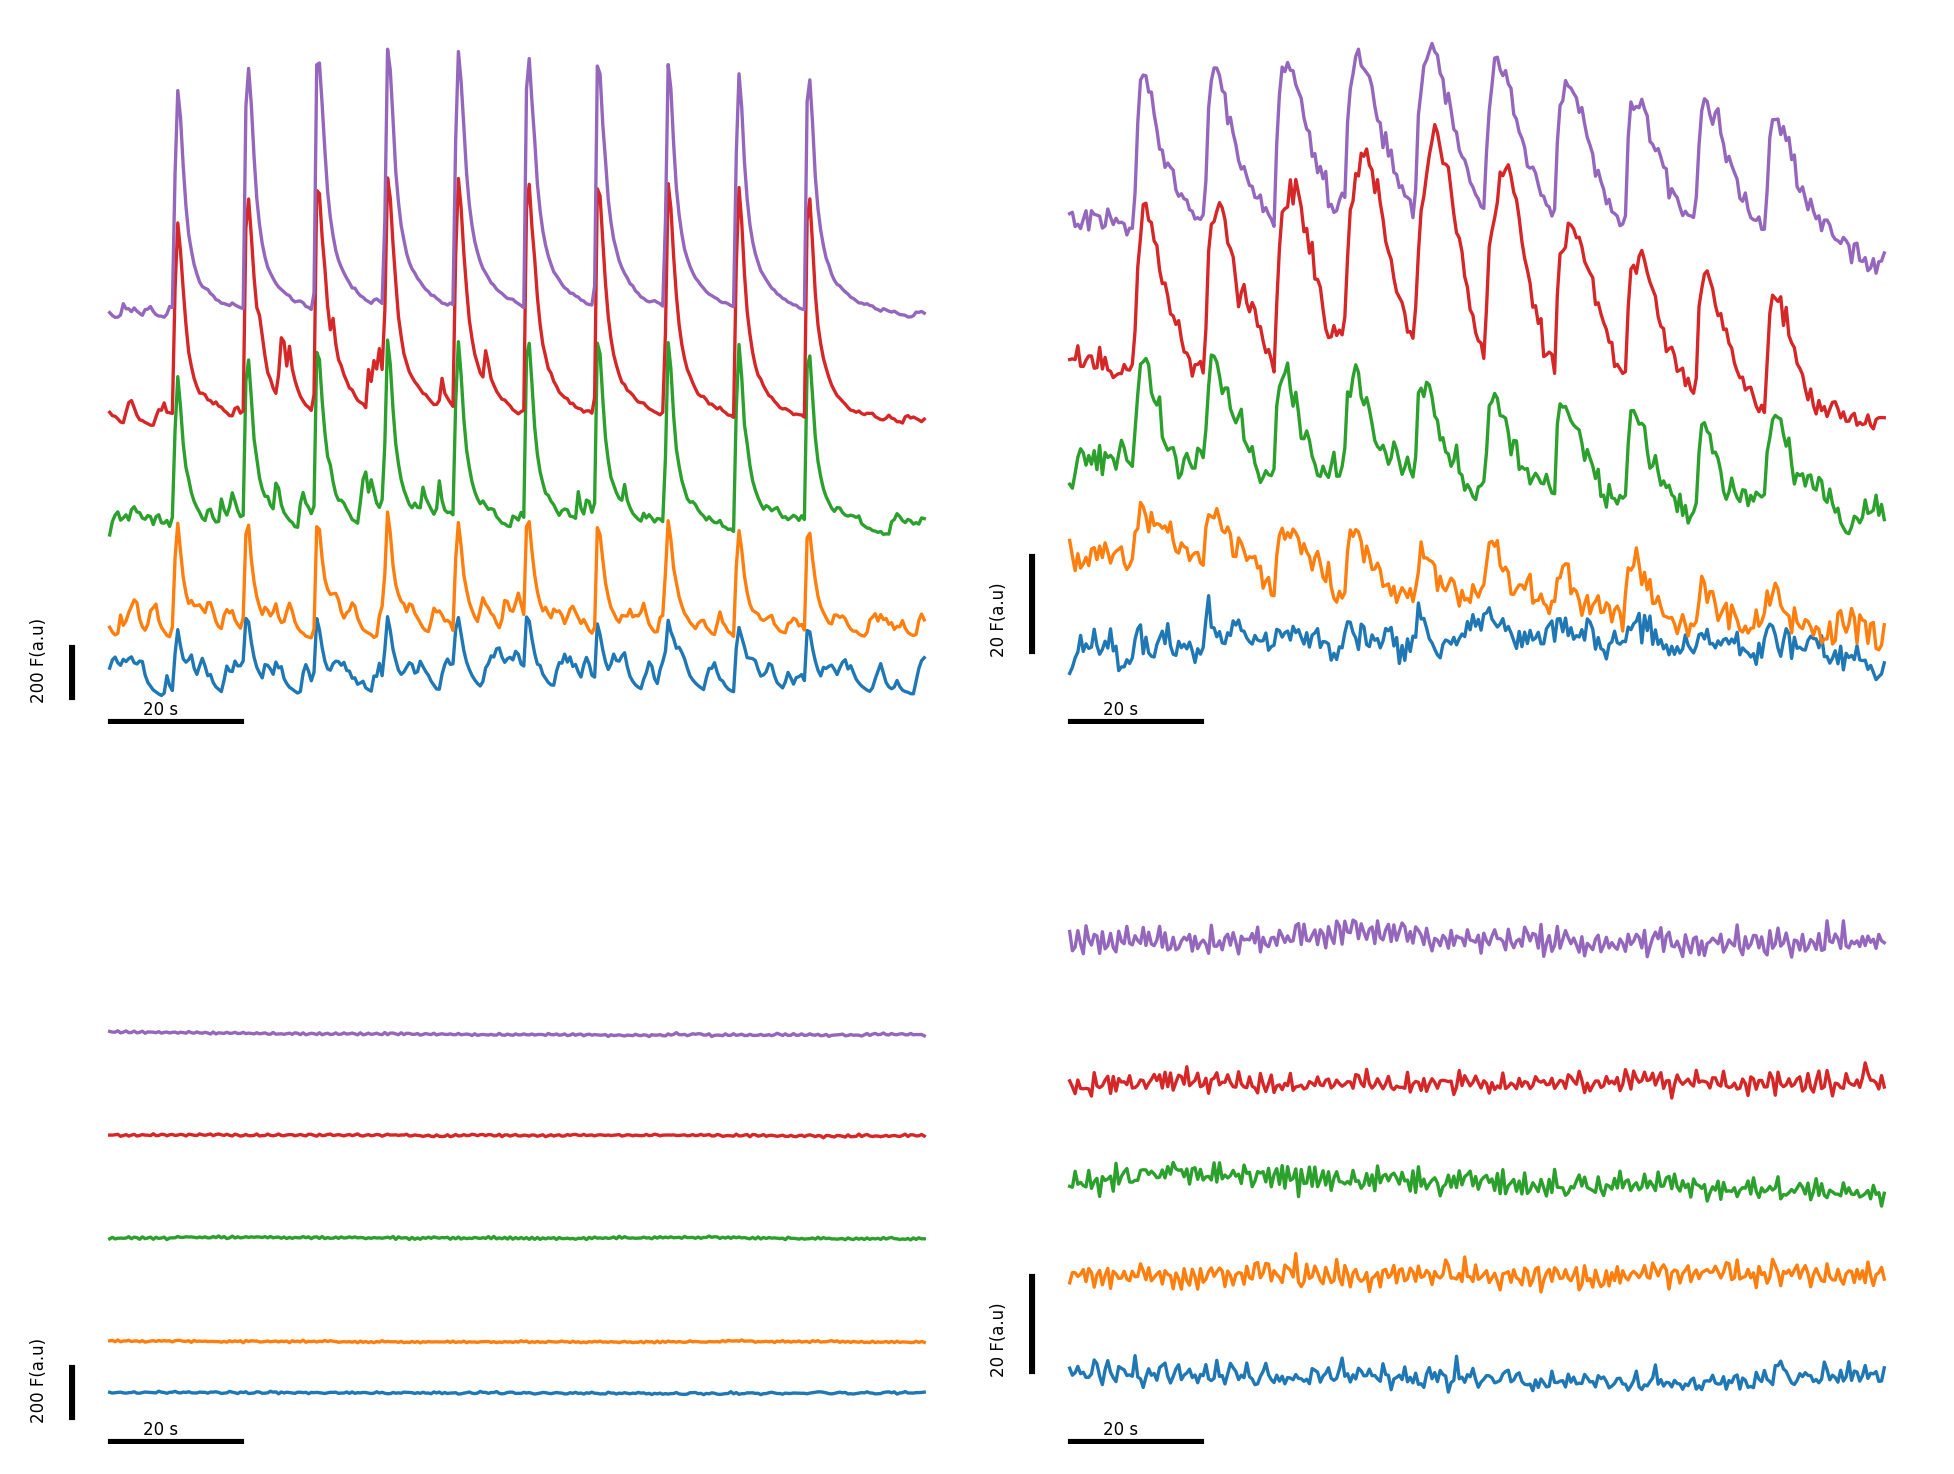

In [ ]:
fig, ax = plt.subplots(2, 2, layout = 'compressed', dpi = 300)
fs = 2.437003460544914
y_axis_height = [200, 20, 200, 20]
offsets = [
    [100, 300, 700, 1100, 1500],
    [0, 20, 40, 60, 90],
    [100, 300, 700, 1100, 1500],
    [0, 20, 40, 60, 90],
]
for row in range(2):
    for col in range(2):
        a = ax[row, col]
        index = row*2 + col
        offset = offsets[index]
        for i, key in enumerate(sorted(all_dics[index].keys())):
            y = all_dics[index][key][:300] + offset[i]
            time = np.arange(y.shape[0])/fs
            a.plot(
                time[:300],
                y,
                label = key,
                linewidth = 0.8
                )
        a.set_xticks([])
        a.set_yticks([])
        for axis in ['top','right','left', 'bottom']:
            a.spines[axis].set_linewidth(0)
        # a.legend()

            
        transform = mtl.transforms.blended_transform_factory(a.transData, a.transAxes)
        rect = ptch.Rectangle((0, 0), width=20, height=0.005, color="black", transform=transform)
        a.add_patch(rect)
        a.text(5, 0.015, "20 s", fontsize = 4, transform = transform)

        transform = mtl.transforms.blended_transform_factory(a.transAxes, a.transData)
        rect = ptch.Rectangle((0, 0), width=0.005, height=y_axis_height[index], color="black", transform=transform)
        a.add_patch(rect)
        a.text(-12, 0.015, f"{y_axis_height[index]} F(a.u)", fontsize = 4, rotation = 90)

ax[0, 0].set_ylim(-100, 2600)
ax[1, 0].set_ylim(-100, 2600)
ax[0, 1].set_ylim(-15, 130)
ax[1, 1].set_ylim(-15, 130)



## E

In [4]:
astrocytes_high_list, neurons_high_list = [], []
astrocytes_low_list, neurons_low_list = [], []

for m_info in input_output.mouse_infos(load_ttx=True, currents='all'):
    if not m_info['is_ttx']:
        continue
    neurons_avg = np.average(m_info['neurons'], axis = (1,2))
    astrocytes_avg = np.average(m_info['astrocytes'], axis = (1, 2))
    ss1 = m_info['stimulations_starts'][0]

    for i, avg in enumerate((neurons_avg, astrocytes_avg)):
        m = np.average(avg[:ss1])
        value = (np.average(avg[ss1:2*ss1]) - m)
        if m_info['current'] < 50:
            l = astrocytes_low_list if i else neurons_low_list
        else:
            l = astrocytes_high_list if i else neurons_high_list
        l.append(value)

-0.385 ± 1.340 (N = 10)
-0.766 ± 1.308 (N = 7)
-0.213 ± 0.852 (N = 10)
0.034 ± 0.342 (N = 7)


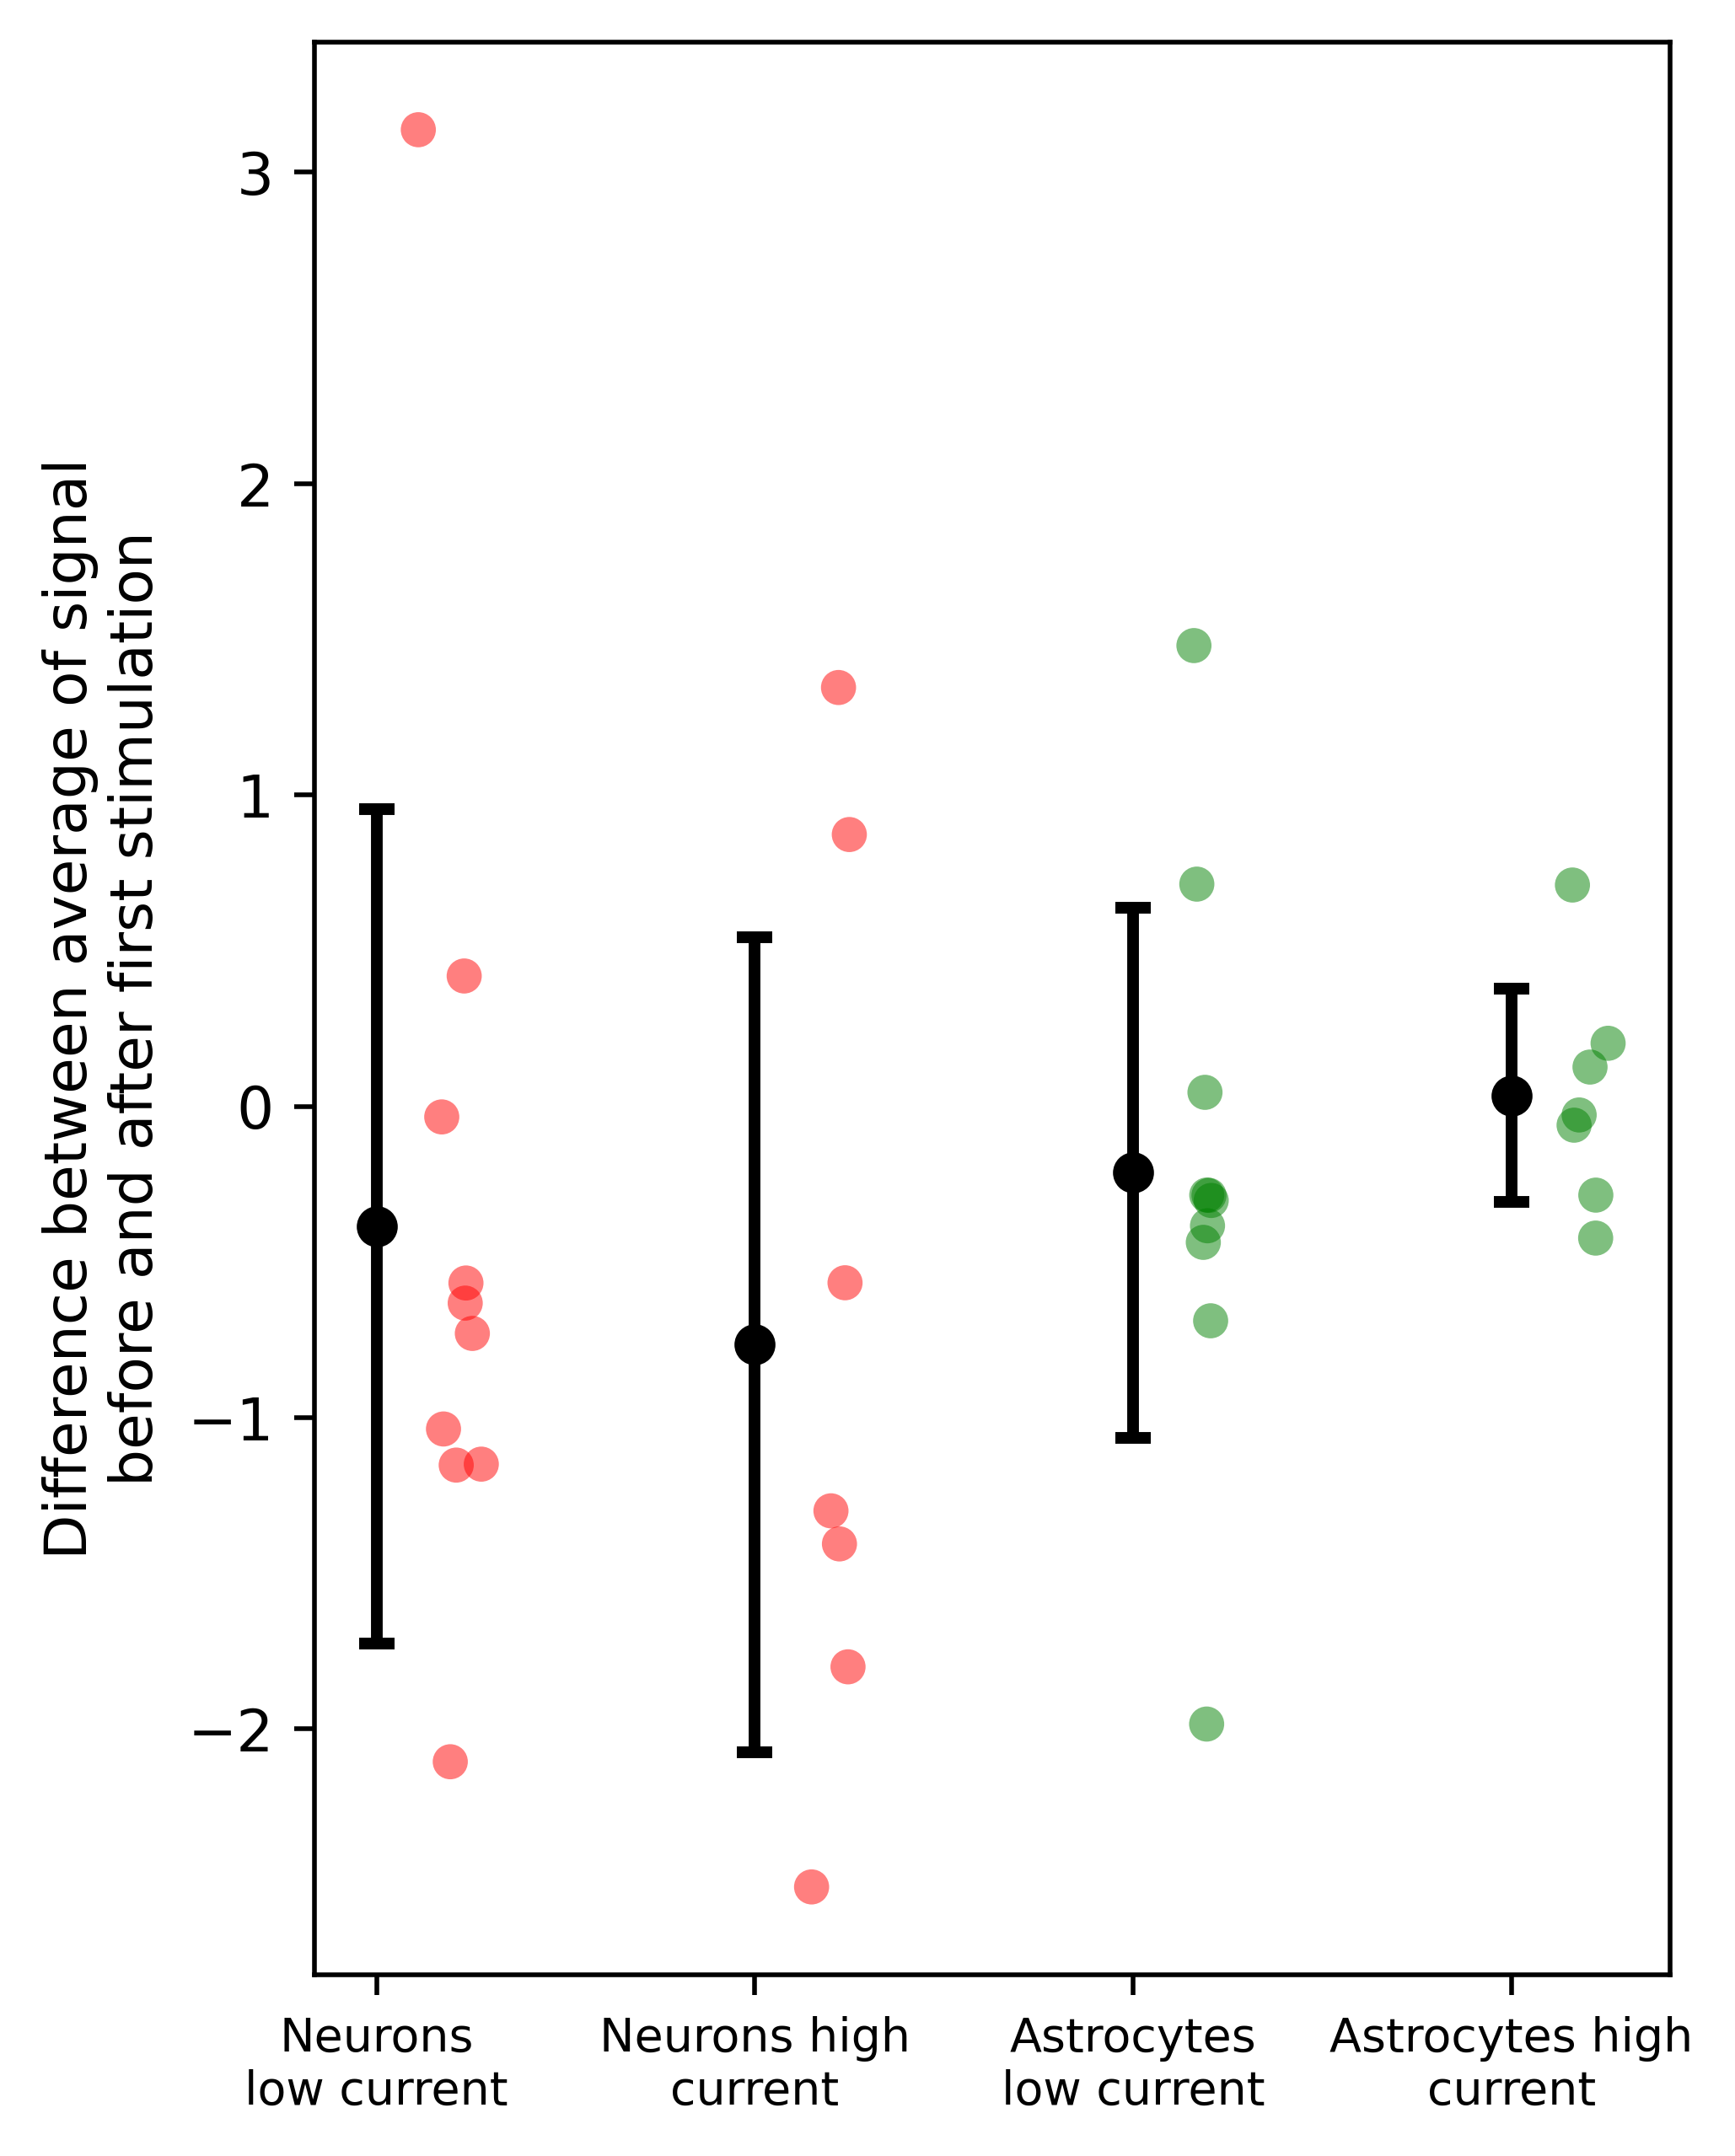

In [5]:
fig, ax = plt.subplots(1, 1, dpi = 500, layout = "compressed", figsize = (4, 5))
for i, l, in enumerate((neurons_low_list, neurons_high_list, astrocytes_low_list, astrocytes_high_list)):
    x = np.random.normal(0.2, 0.05, len(l))
    ax.scatter(x + i, 
               l, 
               color = 'green' if i >=2 else 'red', 
               alpha = 0.5,
               edgecolors='none'
               )
    print(f'{np.average(l):.3f} \u00B1 {np.std(l):.3f} (N = {len(l)})')
    ax.errorbar(i, np.average(l), yerr=np.std(l), color = 'black', fmt = 'o', capsize =3, linewidth = 2, capthick = 2)
    ax.set_xticks([0, 1, 2, 3], 
                  labels = ['Neurons\nlow current',
                            'Neurons high\ncurrent', 
                            'Astrocytes\nlow current', 
                            'Astrocytes high\ncurrent'],
                    fontsize = 8)
    ax.set_ylabel('Difference between average of signal\nbefore and after first stimulation')
# save_fig(fig, "TTX reactivity")

## D

In [6]:
same_rois_ttx = 0
same_rois_clear = 0
active_n_ttx = 0
active_n_clear = 0
active_a_ttx = 0
active_a_clear = 0
all_rois_ttx = 0
all_rois_clear = 0

resp_n_clear = np.empty(0)
resp_a_clear = np.empty(0)
resp_n_ttx = np.empty(0)
resp_a_ttx = np.empty(0)

for m_info in input_output.mouse_infos(load_ttx=True, currents = 'all'):
    na, aa = signal_processing.get_activity(m_info)
    na = np.sum(na, axis = 0).flatten()
    aa = np.sum(aa, axis = 0).flatten()
    if m_info['is_ttx']:
        same_rois_ttx += np.sum((na>0)*(aa>0))
        active_n_ttx += np.sum(na>0)
        active_a_ttx += np.sum(aa>0)
        all_rois_ttx += len(aa)

        resp_n_ttx = np.append(resp_n_ttx, na)
        resp_a_ttx = np.append(resp_a_ttx, aa)
        
    else:
        same_rois_clear += np.sum((na>0)*(aa>0))
        active_n_clear += np.sum(na>0)
        active_a_clear += np.sum(aa>0)
        all_rois_clear += len(aa)


        resp_n_clear = np.append(resp_n_clear, na)
        resp_a_clear = np.append(resp_a_clear, aa)


[]

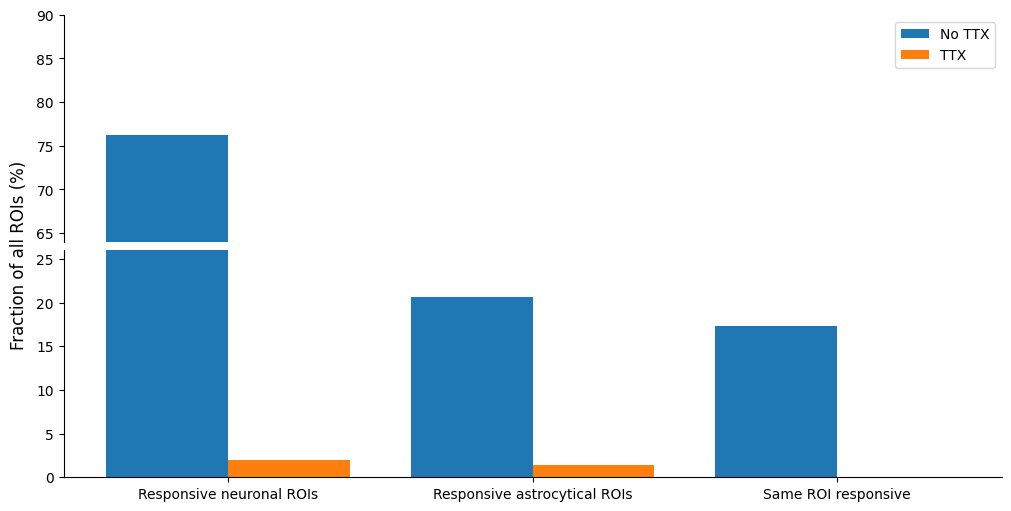

In [7]:
fig, ax = plt.subplots(2, 1, figsize = (10, 5), layout = 'compressed')
x = np.arange(3)
offset = 0.2
ttx_data = np.array([active_n_ttx, active_a_ttx, same_rois_ttx])
clear_data = np.array([active_n_clear, active_a_clear, same_rois_clear])
for a in ax:
    a.bar(x-offset, 100*clear_data/all_rois_clear, width = 0.4, label = 'No TTX')
    a.bar(x+offset, 100*ttx_data/all_rois_ttx, width = 0.4, label = 'TTX')
    for axis in ['top','right']:
        a.spines[axis].set_linewidth(0)
ax[1].set_xticks((0, 1, 2), labels = ('Responsive neuronal ROIs', 'Responsive astrocytical ROIs', 'Same ROI responsive'))
ax[0].legend()
fig.supylabel('Fraction of all ROIs (%)')

ax[0].set_ylim(64, 90)
# ax[0].set_yticks((75, 80))
ax[1].set_ylim(0, 26)
ax[0].spines['bottom'].set_linewidth(0)
ax[0].set_xticks([])

In [8]:
hist_n_clear, _ = np.histogram(resp_n_clear, np.arange(12))
hist_a_clear, _ = np.histogram(resp_a_clear, np.arange(12))
hist_n_ttx, _ = np.histogram(resp_n_ttx, np.arange(12))
hist_a_ttx, _ = np.histogram(resp_a_ttx, np.arange(12))


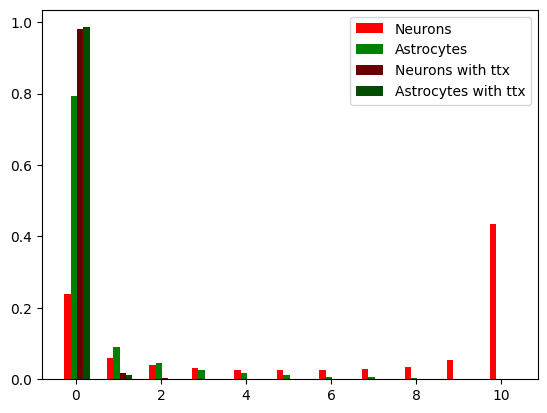

In [9]:
fig, ax = plt.subplots(1, 1)
x = np.arange(11)
colors = ['red', 'green', (0.4, 0, 0), (0, 0.3, 0)]
labels = ['Neurons', 'Astrocytes', 'Neurons with ttx', 'Astrocytes with ttx']
for i, data in enumerate((hist_n_clear, hist_a_clear, hist_n_ttx, hist_a_ttx)):
    data = data/np.sum(data)
    ax.bar(x - 0.2 + i*0.15, data, width = 0.15, color = colors[i], label = labels[i])
ax.legend()

